# The flexible interface

In the previous tutorial, we have demonstrated how `sbi` can be used to run simulation-based inference with just a single line of code.

In addition to this simple interface, `sbi` also provides a **flexible interface** which unlocks several additional features implemented in `sbi`.

## Features

The flexible interface allows you to customize the following:

- performing sequential posterior estimation by using multiple rounds. This can decrease the number of simulations one has to run, but the inference procedure is no longer amortized.  
- specify your own density estimator, or change hyperparameters of existing ones (e.g. number of hidden units for [NSF](https://arxiv.org/abs/1906.04032)).
- run simulations in batches, which can speed up simulations.
- when it makes sense, choose between different methods to sample from the posterior.
- use calibration kernels as proposed by [Lueckmann, Goncalves et al. 2017](https://arxiv.org/abs/1711.01861).

## Linear Gaussian example

In [1]:
import torch

from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
import sbi.utils as utils

We will show an example of how we can use the flexible interface to infer the posterior for an example with a Gaussian likelihood (same example as before). After importing the inference method we want, `SNPE`, a function to prepare the input `prepare_for_sbi` and a factory for density estimators `posterior_nn` above, we define the simulator and prior:

In [2]:
num_dim = 3
prior = utils.BoxUniform(low=-2*torch.ones(num_dim), 
                         high=2*torch.ones(num_dim))

In [3]:
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In the flexible interface, you have to ensure that your simulator and prior adhere the requirements of `sbi`. You can do so with the `prepare_for_sbi()` function.

In [4]:
simulator, prior = prepare_for_sbi(linear_gaussian, prior)

It is possible to specify a custom density estimator. One option is to use one of set of preconfigured density estimators by passing a string in the `density_estimator` keyword argument, e.g., "maf" to use a Masked Autoregressive Flow, of "nsf" to use a Neural Spline Flow with default hyperparameters. Alternatively, you can use a set of utils functions to configure a density estimator yourself, e.g., use a MAF with hyperparameters chosen for your problem at hand. Finally, it is also possible to implement your own density estimator from scratch, e.g., including embedding nets to preprocess data, or to a density estimator architecture of your choice. 

For the last two options the `density_estimator` argument needs to be a function that takes `theta` and `x` batches as arguments to then construct the density estimator after the first set of simulations was generated. Our utils functions in `sbi/utils/get_nn_models` return such a function. 

Here, because we want to use S*N*PE, we specifiy a neural network targeting the *posterior* (using the utils function `posterior_nn`). In this example, we will create a neural spline flow (`'nsf'`) with `60` hidden units and `3` transform layers:

In [5]:
density_estimator_build_fun = posterior_nn(model='nsf', hidden_features=60, num_transforms=3)

We will use `SNPE` with a `simulation_batch_size=10`, i.e. `10` simulations will be passed to the simulator which will then handle the simulations in a vectorized way (note that your simulator has to support this in order to use this feature):

In [6]:
inference = SNPE(simulator, prior, density_estimator=density_estimator_build_fun, 
                 show_progress_bars=False)

And we can run inference. In this example, we will run inference over `2` rounds, potentially leading to a more focused posterior around the observation `x_o`.

In [7]:
num_rounds = 2
x_o = torch.zeros(3,)

posteriors = []
proposal = None

for _ in range(num_rounds):
    posterior = inference(num_simulations=500, proposal=proposal)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Neural network successfully converged after 71 epochs.



Neural network successfully converged after 35 epochs.


 Note that, for `num_rounds>1`, the posterior is no longer amortized: it will give good results when sampled around `x=observation`, but possibly bad results for other `x`.

Once we have obtained the posterior, we can `.sample()`, `.log_prob()`, or `.pairplot()` in the same way as for the easy interface.

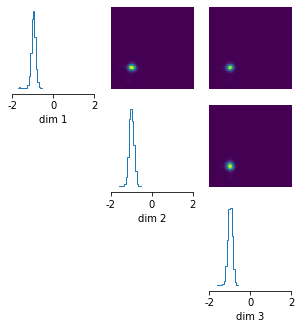

In [8]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = utils.pairplot(posterior_samples, limits=[[-2,2],[-2,2],[-2,2]], 
                   fig_size=(5,5))

We can always print the posterior to know how it was trained:

In [9]:
print(posterior)

Posterior conditional density p(θ|x) (multi-round). Evaluates and samples by default at x=[[0.0, 0.0, 0.0]].

This neural posterior was obtained with a SNPE-class method using a flow.
